# P1 - TSA - Acceso a Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [2]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex
from pandas import Series
from tabulate import tabulate

%matplotlib inline
sns.set()  

In [3]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Acceso_Internet_Trim.xlsx",index_col=0)

# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

Para el desarrollo del proyecto, se utilizó la serie de tiempo del porcentaje de penetración de Internet dedicado en Colombia (% de la población).

Número de suscriptores con acceso a Internet, fijo y móvil, según los datos reportados por los proveedores al último día de cada trimestre como porcentaje de la población basados en las proyecciones de población del DANE.

Fuente: Ministerio de las TIC https://colombiatic.mintic.gov.co/

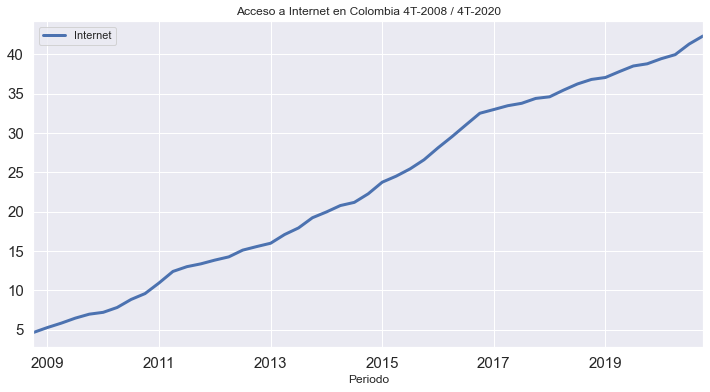

In [4]:
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Acceso a Internet en Colombia 4T-2008 / 4T-2020');

In [5]:
df.Internet.describe()

count    49.000000
mean     23.267556
std      11.852783
min       4.633165
25%      13.362776
50%      22.276354
75%      34.406101
max      42.350991
Name: Internet, dtype: float64

In [6]:
table_Latam = [['Colombia','64.1%'],['Argentina','68.2%'],['Brasil','70.4%'],['México','65.8%'],['Perú','55.1%'],['Uruguay','74.8%']]
headers = ['País', 'año 2018']
print(tabulate(table_Latam,headers))

País       año 2018
---------  ----------
Colombia   64.1%
Argentina  68.2%
Brasil     70.4%
México     65.8%
Perú       55.1%
Uruguay    74.8%


In [7]:
table_GP = [['Alemania','87.0%'],['China','90.5%'],['Estados Unidos','88.5%'],['Japón','91.3%'],['OECD','82.8%'],['Reino Unido','90.7%']]
headers = ['País', 'año 2018']
print(tabulate(table_GP,headers))

País            año 2018
--------------  ----------
Alemania        87.0%
China           90.5%
Estados Unidos  88.5%
Japón           91.3%
OECD            82.8%
Reino Unido     90.7%


# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

# Estacionariedad

In [8]:
#DF Test
result = adfuller(df['Internet'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.040810
p-value: 0.955024
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

# Tendencia

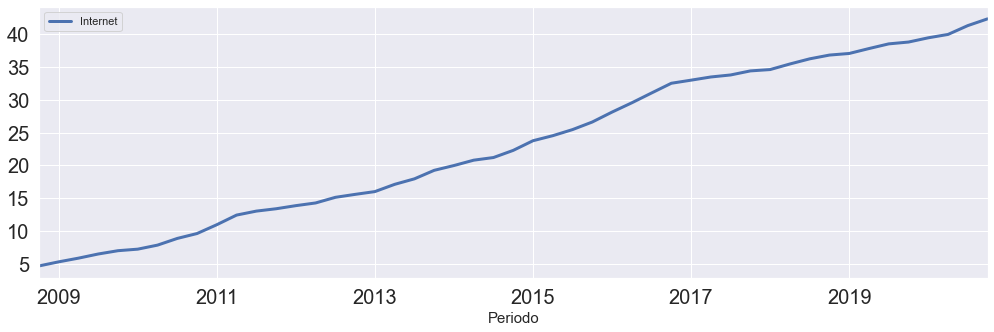

In [9]:
df.rolling(1).mean().plot(figsize=(17,5), linewidth=3, fontsize=20)
plt.xlabel('Periodo', fontsize=15);

# Serie sin Tendencia

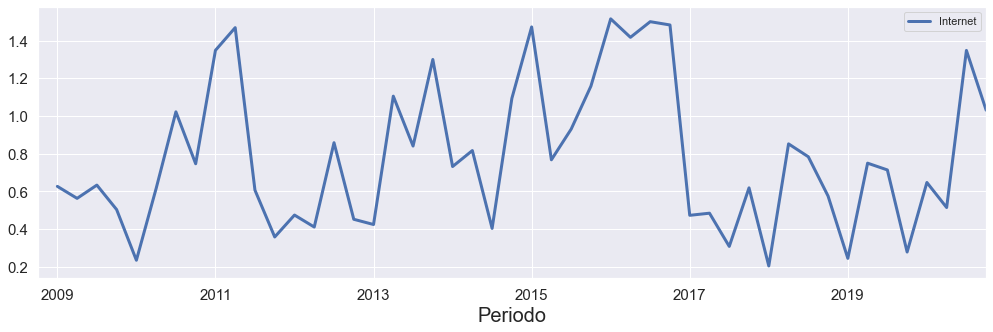

In [10]:
df.diff().plot(figsize=(17,5), linewidth=3, fontsize=15)
plt.xlabel('Periodo', fontsize=20);

In [48]:
result = adfuller(df['Internet'].diff().iloc [ 1 :]) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.179342
p-value: 0.000714
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


Al eliminar la tendencia, la serie es estacionaria.

# Estacionalidad

# Autocorrelación

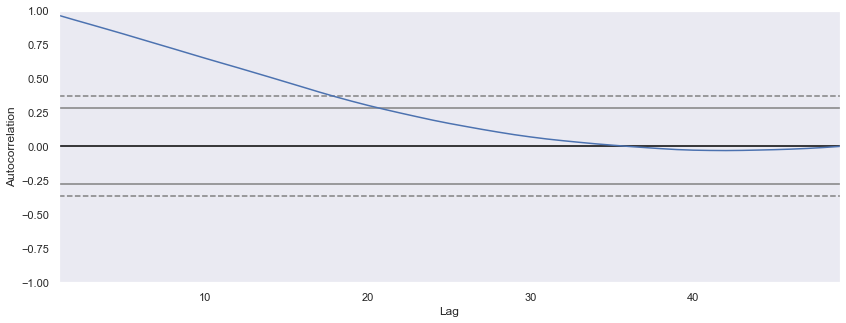

In [50]:
plt.figure(figsize=(14,5))
pd.plotting.autocorrelation_plot(df);

# Parte C. Modelos y Proyecciones

In [13]:
warnings.filterwarnings('ignore')

## C.1. Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

## 1. Modelos

Se transforma la serie en logaritmo y se diferencia una vez:

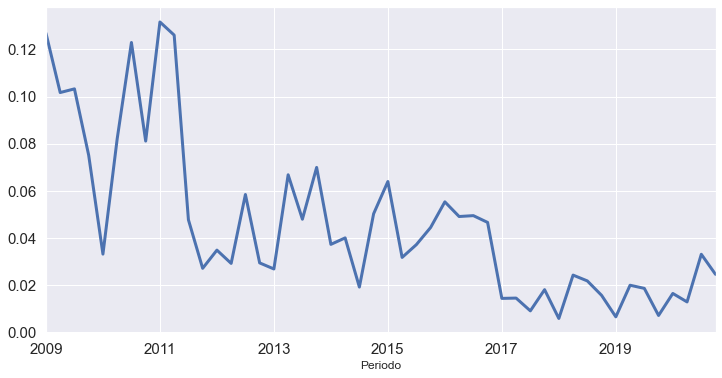

In [14]:
df['log_Internet'] = np.log(df['Internet'])
df_log=df.iloc[:,1:3]
df_log= df.log_Internet.diff()
df_log=df_log.dropna()
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [15]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.297381
p-value: 0.014996
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


La serie diferenciada una vez mas, es estacionaria. 

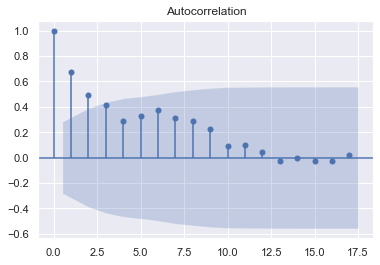

In [17]:
# Función de Autocorrelación
serie = np.log(df['Internet']).diff().dropna()
plot_acf(serie);

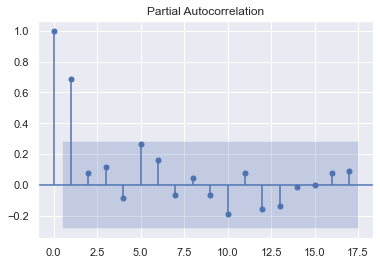

In [25]:
#Función de Autocorrelación Parcial
plot_pacf(serie);

In [21]:
#Bases de train y test
X = df['Internet'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

In [22]:
# fit modelo 1 - ARIMA(2,1,3)
model1 = ARIMA(np.log(history), order=(2,1,3))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  83.129
Method:                       css-mle   S.D. of innovations              0.027
Date:                Wed, 14 Jul 2021   AIC                           -152.258
Time:                        00:43:12   BIC                           -140.795
Sample:                             1   HQIC                          -148.180
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0545      0.007      7.540      0.000       0.040       0.069
ar.L1.D.y      0.0528      0.118      0.449      0.653      -0.178       0.283
ar.L2.D.y      0.9472      0.120      7.869      0.0

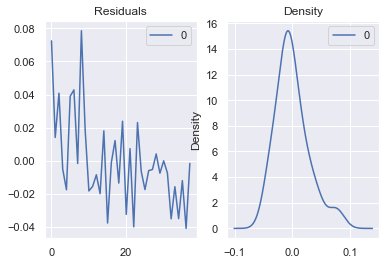

In [23]:
# plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  37.451142  36.247135
1  39.522632  36.822584
2  41.781185  37.067690
3  44.096223  37.817613
4  46.612087  38.531663
5  49.198848  38.810409
6  52.001781  39.457992
7  54.891700  39.972537
8  58.014906  41.320338
9  61.243051  42.350991


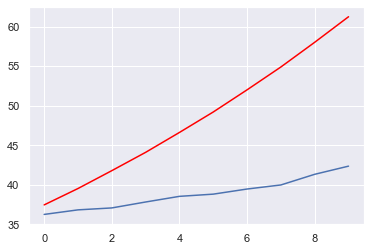

Test MSE: 125.914


In [24]:
# Real vs Proyectado
output = model1_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse1 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse1)

In [53]:
# fit modelo 2 - ARIMA(2,1,1)
model2 = ARIMA(np.log(history), order=(2,1,1))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  85.204
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 14 Jul 2021   AIC                           -160.409
Time:                        00:54:31   BIC                           -152.221
Sample:                             1   HQIC                          -157.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0558      0.010      5.442      0.000       0.036       0.076
ar.L1.D.y      1.6811      0.125     13.480      0.000       1.437       1.925
ar.L2.D.y     -0.6897      0.122     -5.644      0.0

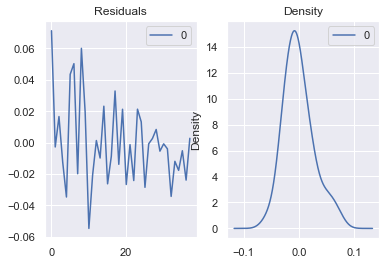

In [54]:
# plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  36.709762  36.247135
1  38.275843  36.822584
2  40.113104  37.067690
3  42.190137  37.817613
4  44.487033  38.531663
5  46.991943  38.810409
6  49.698846  39.457992
7  52.606069  39.972537
8  55.715259  41.320338
9  59.030679  42.350991


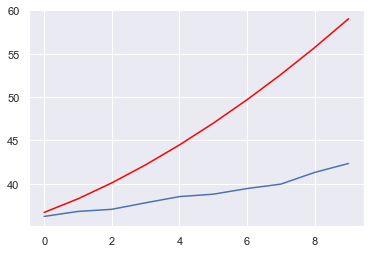

Test MSE: 88.303


In [55]:
#Real vs Proyectado
output = model2_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse2 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse2)

In [56]:
# fit modelo 3 - ARIMA(2,1,0)
model3 = ARIMA(np.log(history), order=(2,1,0))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  85.104
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 14 Jul 2021   AIC                           -162.208
Time:                        00:56:02   BIC                           -155.658
Sample:                             1   HQIC                          -159.877
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0560      0.013      4.198      0.000       0.030       0.082
ar.L1.D.y      0.6708      0.164      4.087      0.000       0.349       0.992
ar.L2.D.y      0.0358      0.172      0.208      0.8

     predict       real
0  36.651962  36.247135
1  38.125853  36.822584
2  39.843472  37.067690
3  41.777935  37.817613
4  43.911980  38.531663
5  46.235214  38.810409
6  48.742278  39.457992
7  51.431602  39.972537
8  54.304547  41.320338
9  57.364795  42.350991


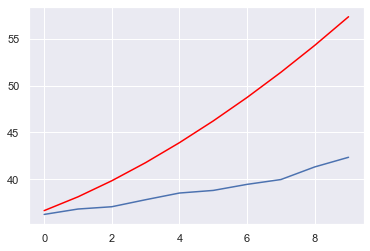

Test MSE: 72.084


In [57]:
#Real vs Proyectado
output = model3_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse3 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse3)

In [60]:
# Comparación de MSE
table_MSE = [['ARIMA (2,1,3)', round(mse1,1)],['ARIMA (2,1,1)', round(mse2,1)],['ARIMA (2,1,0)', round(mse3,1)]]
headers = ['Modelo', 'MSE ']
print(tabulate(table_MSE,headers,stralign="decimal"))

       Modelo    MSE
-------------  ------
ARIMA (2,1,3)   125.9
ARIMA (2,1,1)    88.3
ARIMA (2,1,0)    72.1


Se selecciona el modelo ARIMA(2,1,0) por tener menor MSE.

## 2. Proyección a 3 años (fuera de la muestra)

In [61]:
#Modelo final con todos los datos
model_def = ARIMA(np.log(X), order=(2,1,0))
model_def_fit = model_def.fit(disp=0)
print(model_def_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   48
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 111.773
Method:                       css-mle   S.D. of innovations              0.023
Date:                Wed, 14 Jul 2021   AIC                           -215.547
Time:                        00:57:08   BIC                           -208.062
Sample:                             1   HQIC                          -212.718
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0502      0.014      3.487      0.000       0.022       0.078
ar.L1.D.y      0.6887      0.146      4.727      0.000       0.403       0.974
ar.L2.D.y      0.0911      0.150      0.609      0.5

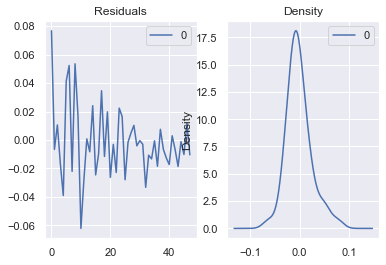

In [62]:
# plot residual errors
residuals = pd.DataFrame(model_def_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

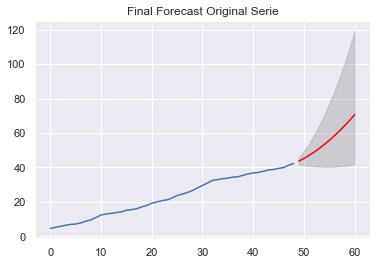

In [63]:
#Proyección por fuera de la muestra
n_periods = 12
fc, se, conf = model_def_fit.forecast(steps=n_periods)

#Extraer series
index_of_fc = np.arange(len(X), len(X)+n_periods)
fc_serie = np.exp(pd.Series(fc, index=index_of_fc))
lower_serie = np.exp(pd.Series(conf[:, 0], index=index_of_fc))
upper_serie = np.exp(pd.Series(conf[:, 1], index=index_of_fc))

# Gráfico
plt.plot(X)
plt.plot(fc_serie, color='red')
plt.fill_between(lower_serie.index,lower_serie, upper_serie, 
                 color='k', alpha=.15)
plt.title("Final Forecast Original Serie")
plt.show()

In [64]:
años=['1T-21','2T-21','3T-21','4T-21','1T-22','2T-22','3T-22','4T-22','1T-23','2T-23','3T-23','4T-23']
años=pd.DataFrame(años)
table_proy = [[años[-0],round(fc_serie[:],1), round(lower_serie,1), round(upper_serie,1)]]
headers = ['Año','Proyección', 'Límite inferior','Límite superior']
print(tabulate(table_proy,headers))

Año                     Proyección      Límite inferior    Límite superior
----------------------  --------------  -----------------  -----------------
0     1T-21             49    43.7      49    41.7         49     45.7
1     2T-21             50    45.2      50    41.3         50     49.5
2     3T-21             51    47.0      51    41.0         51     53.9
3     4T-21             52    48.9      52    40.7         52     58.8
4     1T-22             53    51.0      53    40.4         53     64.3
5     2T-22             54    53.3      54    40.3         54     70.4
6     3T-22             55    55.7      55    40.3         55     77.0
7     4T-22             56    58.4      56    40.4         56     84.2
8     1T-23             57    61.2      57    40.6         57     92.0
9     2T-23             58    64.1      58    40.9         58    100.5
10    3T-23             59    67.3      59    41.3         59    109.6
11    4T-23             60    70.6      60    41.8         60    11

## C.2. Modelo Prophet

In [65]:
df['log_Internet'] = np.log(df['Internet'])
df_log=df.iloc[:,1:3]
df_log=df_log.dropna()
df2=df_log.iloc[:,]
df2.rename(columns=df2.iloc[0]).drop(df2.index[0])
df2.head()

,log_Internet
Periodo,
2008-12-31,1.533240
2009-03-31,1.660152
2009-06-30,1.761886
2009-09-30,1.865170
2009-12-31,1.940300


## 1. Modelo ###

In [66]:
df_log.columns = ['ds', 'y']
df_log.head()
m = Prophet()
m.fit(df_log)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

## 2. Proyección a 1 año (fuera de la muestra) ###

In [67]:
future = m.make_future_dataframe(periods=12, freq='TS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

NameError: name 'm' is not defined

# Conclusiones

### $\color{red}{\text{TODOS}}$ 